In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping

In [2]:
# Parameters
stocks = 'TSLA'
start_date = '2014-01-01'
end_date = '2024-12-31'
input_days_list = [60, 30, 10, 5]  # Different input days for training

In [3]:
# Download stock data
df = yf.download(stocks, start=start_date, end=end_date)
df.reset_index(inplace=True)

# Data Preparation
features = df['Close'].values
features = features.astype('float32')

[*********************100%***********************]  1 of 1 completed


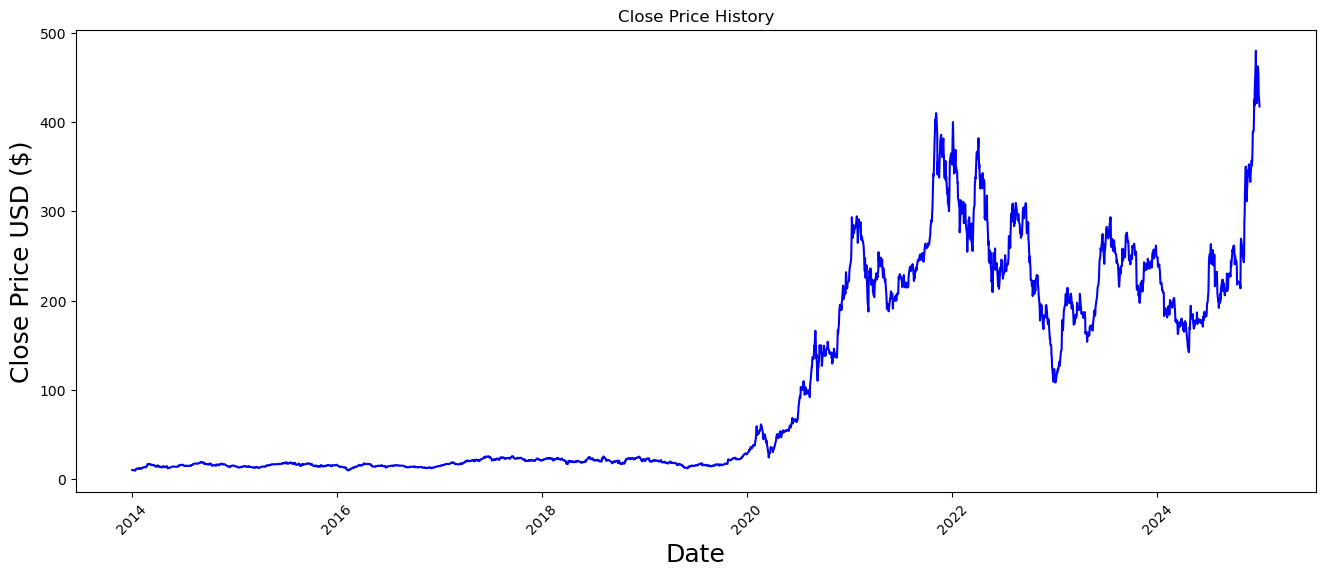

In [4]:
# Plotting the closing price
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], color='blue')
plt.title('Close Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [5]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features.reshape(-1, 1))

# Prepare sequences
training_data_len = int(np.ceil(len(scaled_features) * 0.8))

In [6]:
# Create a function to train, predict, and visualize with various input days
def train_and_predict(input_days):
    # Create training data
    train_data = scaled_features[:training_data_len]
    x_train, y_train = [], []

    for i in range(input_days, len(train_data)):
        x_train.append(train_data[i-input_days:i])
        y_train.append(train_data[i])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Reshape x_train for LSTM
    x_train = x_train.reshape(-1, input_days, 1)

    # Create testing data
    test_data = scaled_features[training_data_len - input_days:]
    x_test, y_test = [], []

    for i in range(input_days, len(test_data)):
        x_test.append(test_data[i-input_days:i])
        y_test.append(test_data[i])

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Reshape x_test for LSTM
    x_test = x_test.reshape(-1, input_days, 1)

    # Initialize and compile the model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_test, y_test), verbose=1, shuffle=False)

    # Make predictions
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)

    # Inverse transform the predictions to get the actual prices
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)

    # Visualization of Predictions
    train = df[:training_data_len]
    valid = df[training_data_len:].copy()
    valid['Predictions'] = test_predictions.flatten()

    plt.figure(figsize=(16, 6))
    plt.title(f'LSTM Model Predictions with {input_days} Days Input')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Date'], train['Close'], label='Train')
    plt.plot(valid['Date'], valid['Close'], label='Val', color='green')
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions', color='orange')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate performance metrics
    mse = mean_squared_error(valid['Close'], valid['Predictions'])
    mae = mean_absolute_error(valid['Close'], valid['Predictions'])
    rmse = np.sqrt(mse)
    r2 = r2_score(valid['Close'], valid['Predictions'])

    print(f"Performance metrics for input days {input_days}:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("\n")

    # Plot train and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
    plt.title(f'Model Train vs Validation Loss with {input_days} Days Input')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    # Predict the next day using the last input_days
    last_input_days = scaled_features[-input_days:]
    last_input_days = last_input_days.reshape((1, input_days, 1))

    predicted_price = model.predict(last_input_days)
    predicted_price = scaler.inverse_transform(predicted_price)

    # Display the next day's predicted price
    next_day_date = df['Date'].iloc[-1] + pd.Timedelta(days=1)
    predicted_df = pd.DataFrame(data=predicted_price, index=[next_day_date], columns=['Predicted Close'])

    print(f"Predicted stock price for {next_day_date.date()} (using last {input_days} days): ${predicted_price[0][0]:.2f}")

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Close'], label='Historical Close Prices', color='blue')
    plt.axvline(x=next_day_date, color='orange', linestyle='--', label='Prediction Date')
    plt.scatter(next_day_date, predicted_price, color='red', label='Predicted Price', s=100)

    # Add titles and labels
    plt.title('Predicted Next Day Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/1000


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4.8682e-04 - val_loss: 0.0034
Epoch 2/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 3/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 4/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0098 - val_loss: 0.0048
Epoch 5/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0127 - val_loss: 0.0041
Epoch 6/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0094 - val_loss: 0.0040
Epoch 7/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 8/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 9/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 10/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 11/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 12/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/s

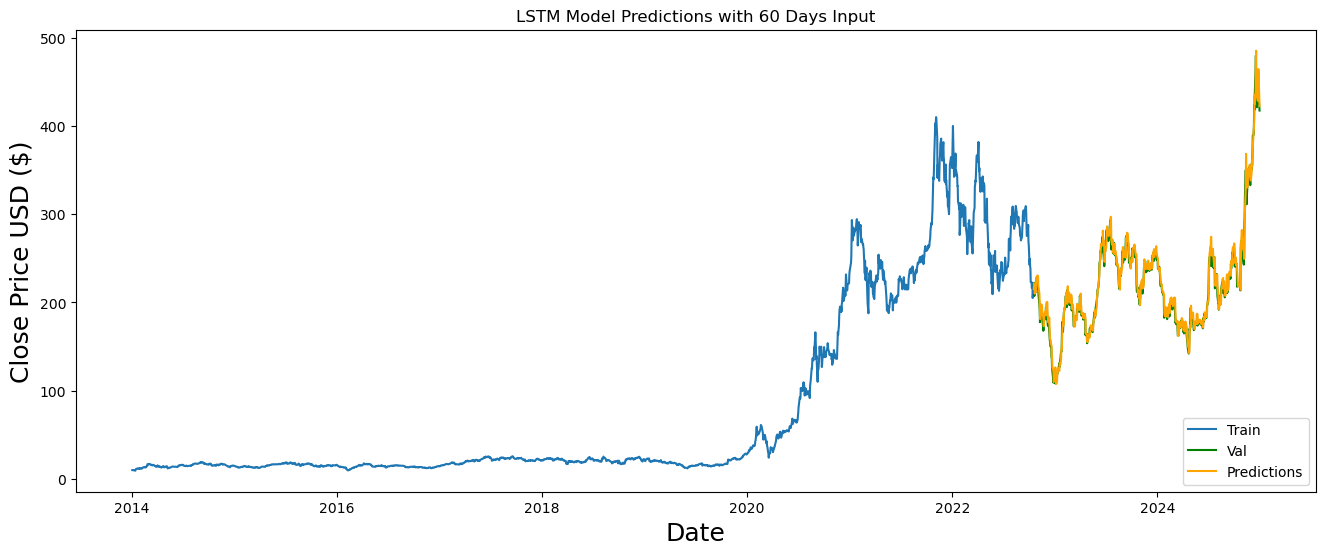

Performance metrics for input days 60:
R² Score: 0.9750
Mean Absolute Error (MAE): 6.4624
Mean Squared Error (MSE): 82.7977
Root Mean Squared Error (RMSE): 9.0993




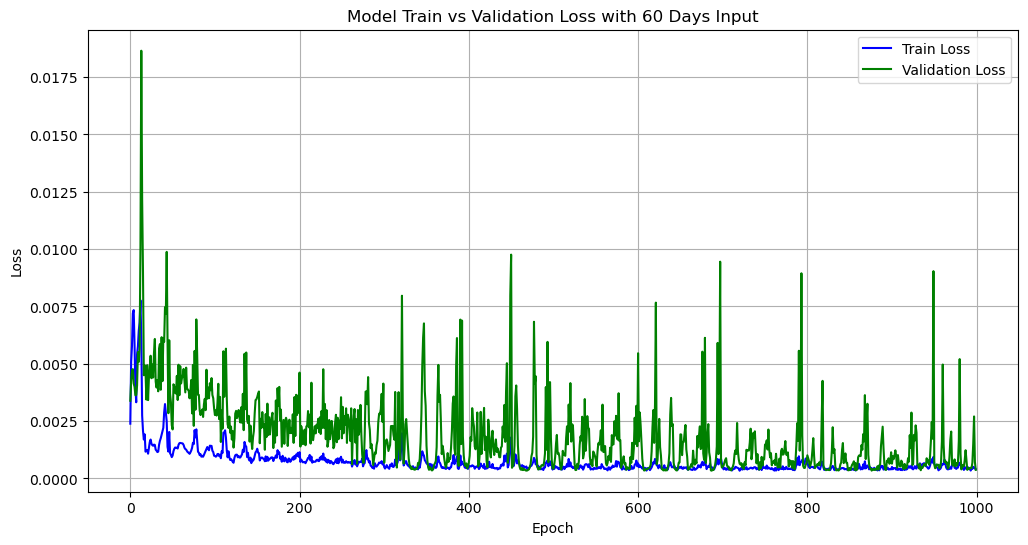

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted stock price for 2024-12-31 (using last 60 days): $420.24


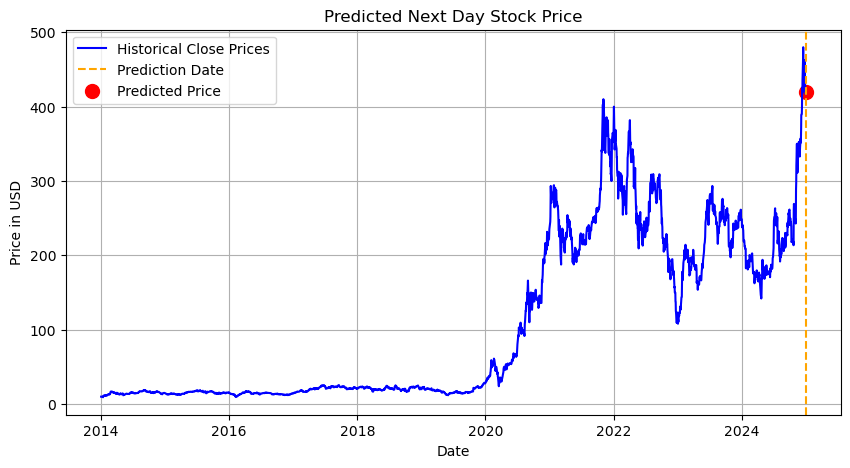

Epoch 1/1000


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 4.6010e-04 - val_loss: 0.0034
Epoch 2/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 3/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 4/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0146 - val_loss: 0.0044
Epoch 5/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0099 - val_loss: 0.0042
Epoch 6/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0082 - val_loss: 0.0040
Epoch 7/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 8/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 10/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 11/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 12/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/s

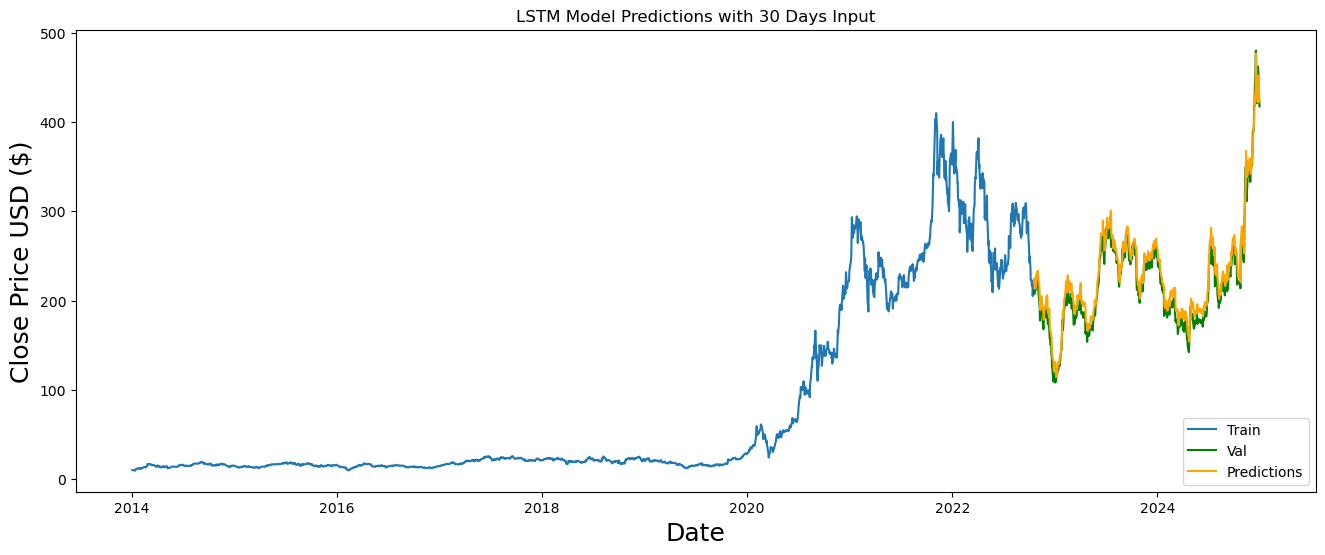

Performance metrics for input days 30:
R² Score: 0.9492
Mean Absolute Error (MAE): 10.8464
Mean Squared Error (MSE): 168.1439
Root Mean Squared Error (RMSE): 12.9670




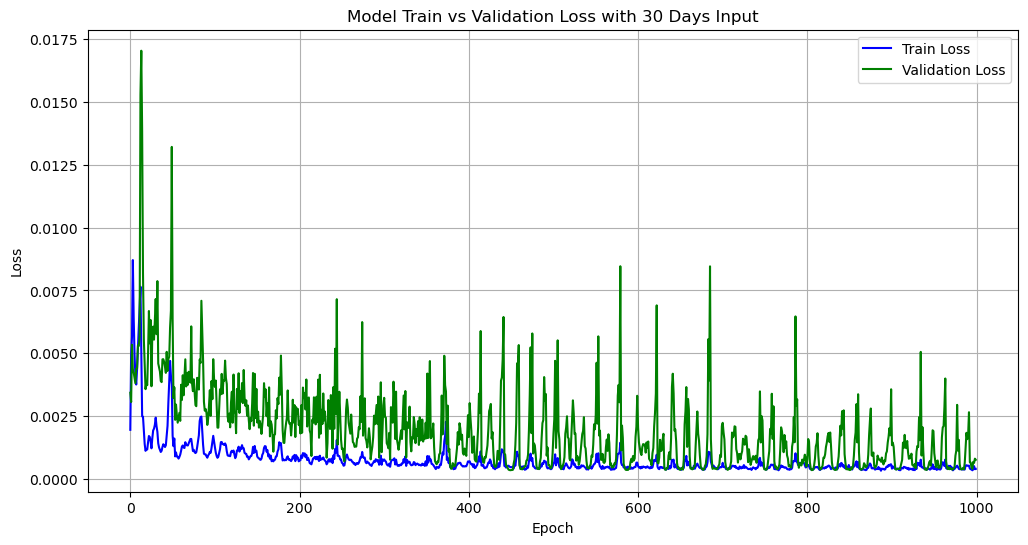

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted stock price for 2024-12-31 (using last 30 days): $416.81


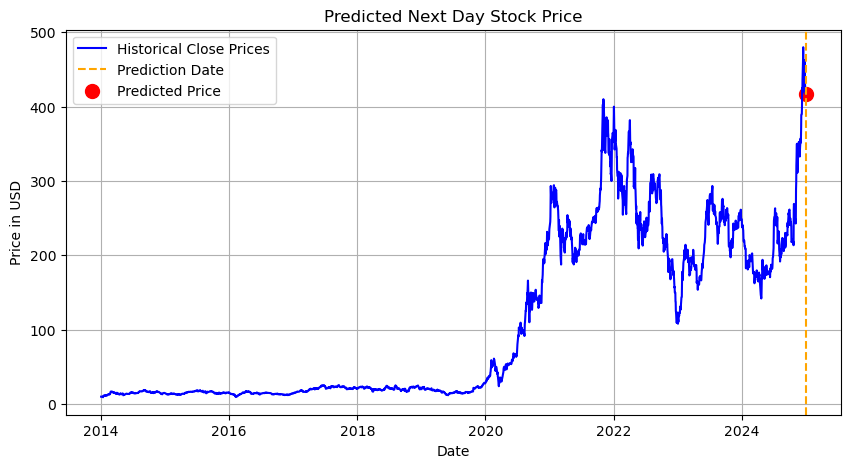

Epoch 1/1000


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.1988e-04 - val_loss: 0.0116
Epoch 2/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - val_loss: 0.0076
Epoch 3/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0193 - val_loss: 0.0081
Epoch 4/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - val_loss: 0.0076
Epoch 5/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0195 - val_loss: 0.0109
Epoch 6/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0174 - val_loss: 0.0442
Epoch 7/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 - val_loss: 0.0128
Epoch 8/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 9/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 10/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2610e-04 - val_loss: 0.0043
Epoch 11/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3280e-04 - val_loss: 0.0037
Epoch 12/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

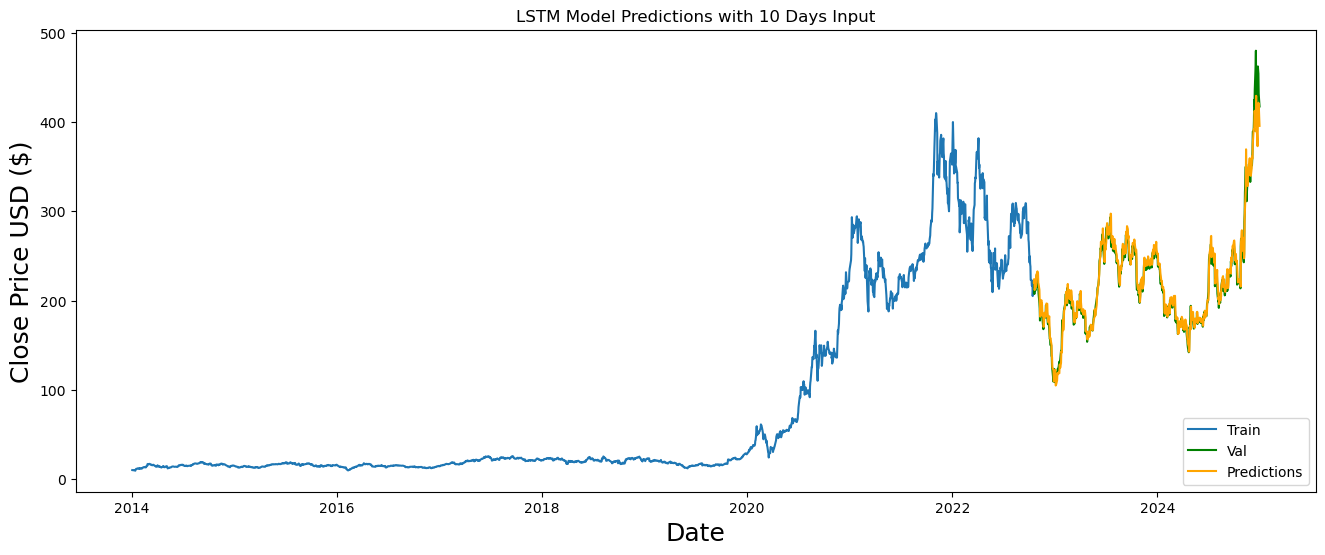

Performance metrics for input days 10:
R² Score: 0.9635
Mean Absolute Error (MAE): 7.1809
Mean Squared Error (MSE): 120.7022
Root Mean Squared Error (RMSE): 10.9865




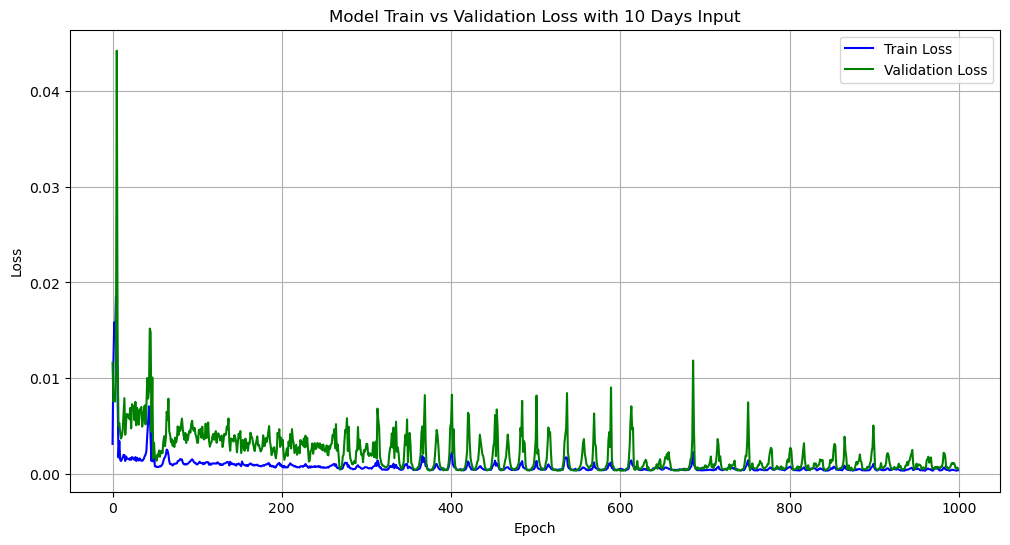

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted stock price for 2024-12-31 (using last 10 days): $388.79


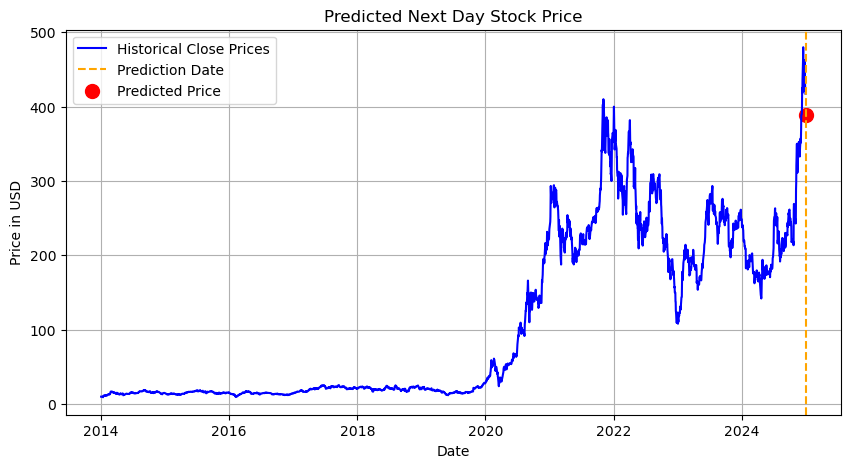

Epoch 1/1000


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.4376e-04 - val_loss: 0.0061
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.0060
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.0156
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - val_loss: 0.0393
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 - val_loss: 0.0014
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 9/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 10/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 11/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1318e-04 - val_loss: 0.0037
Epoch 12/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

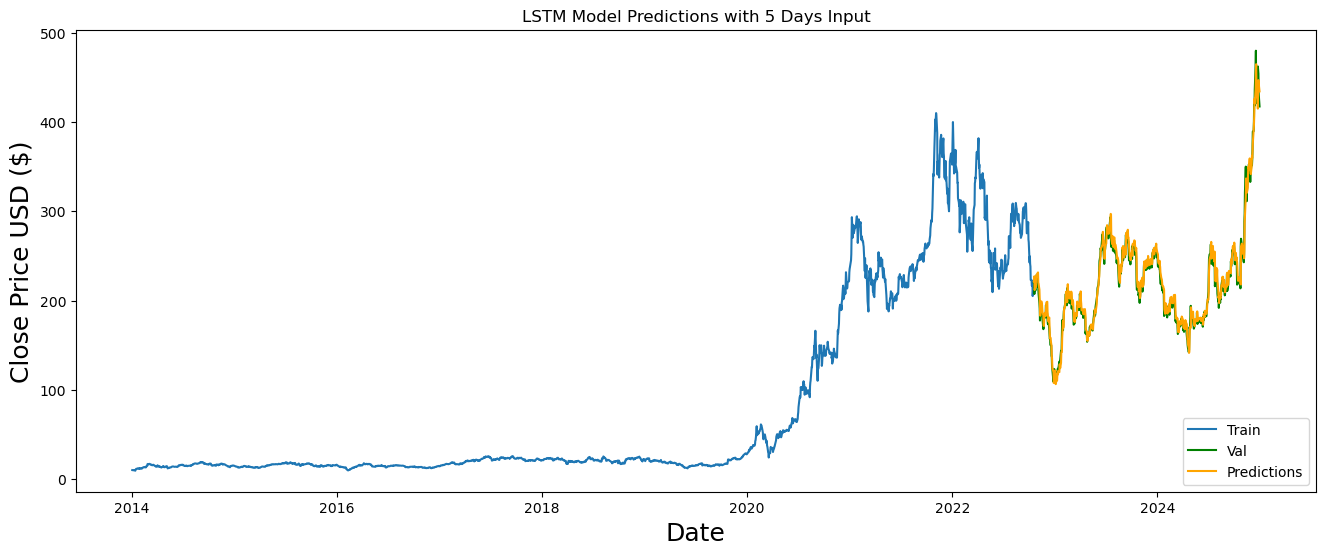

Performance metrics for input days 5:
R² Score: 0.9746
Mean Absolute Error (MAE): 6.7507
Mean Squared Error (MSE): 84.1947
Root Mean Squared Error (RMSE): 9.1758




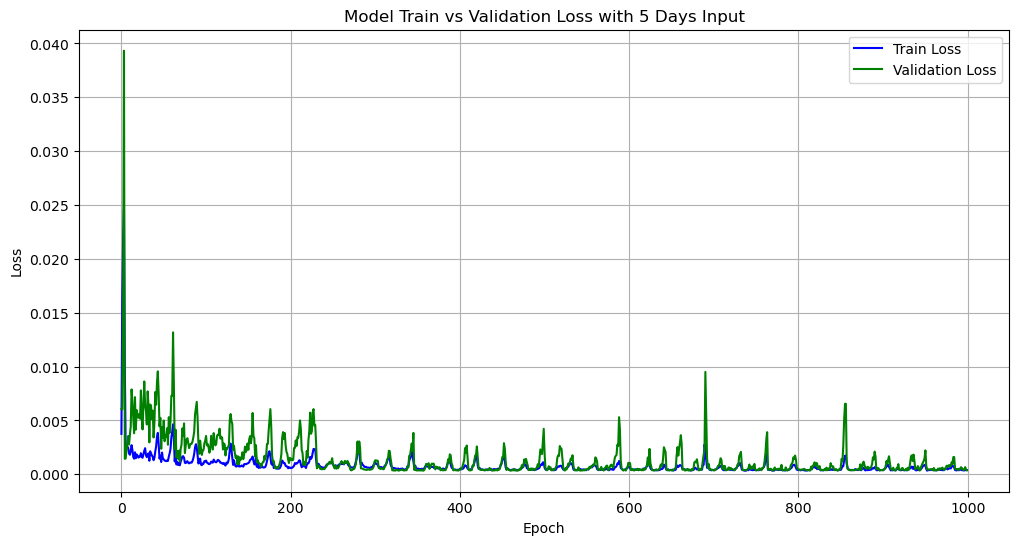

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted stock price for 2024-12-31 (using last 5 days): $420.41


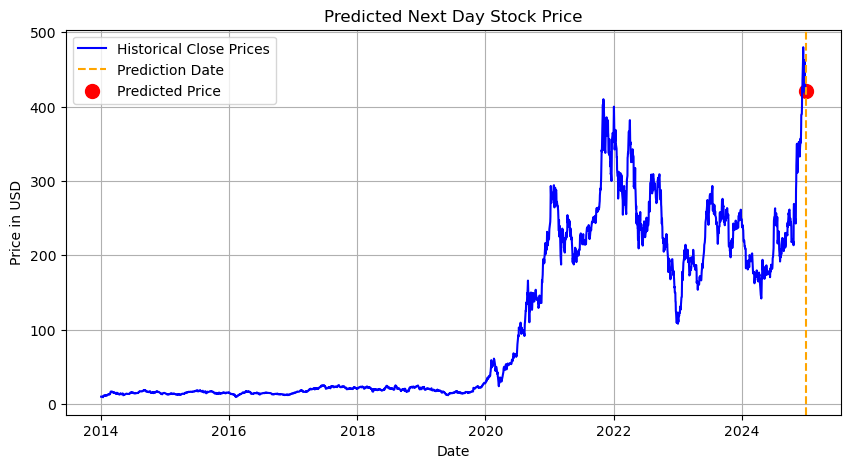

In [7]:
# Loop through different input lengths
for input_days in input_days_list:
    train_and_predict(input_days)